# Cargar y preprocesar imágenes

In [35]:
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.python.keras import layers
import numpy as np
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


IMAGE_SIZE = 180
BATCH_SIZE = 32
CHANNELS = 3 # todavia no se que es esto
EPOCHS = 50 # ya se vera cual es el numero correcto // habia que hacer un rico for para ver que numero es

## Separamos las fotos en imagenes de entrenamiento (80%) y validación (20%) 

In [49]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  "Aves v3",
  labels='inferred',
  label_mode='categorical',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(IMAGE_SIZE, IMAGE_SIZE),
  batch_size=BATCH_SIZE)

val_ds = tf.keras.utils.image_dataset_from_directory(
  "Aves v3",
  labels='inferred',
  label_mode='categorical',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(IMAGE_SIZE, IMAGE_SIZE),
  batch_size=BATCH_SIZE)

Found 1075 files belonging to 7 classes.
Using 860 files for training.
Found 1075 files belonging to 7 classes.
Using 215 files for validation.


In [28]:
class_names = train_ds.class_names
indices = np.arange(len(class_names))
num_classes = len(class_names)
class_names

['ABBOTTS BABBLER',
 'ABBOTTS BOOBY',
 'ABYSSINIAN GROUND HORNBILL',
 'AFRICAN CROWNED CRANE',
 'AFRICAN EMERALD CUCKOO',
 'AFRICAN FIREFINCH',
 'AFRICAN OYSTER CATCHER']

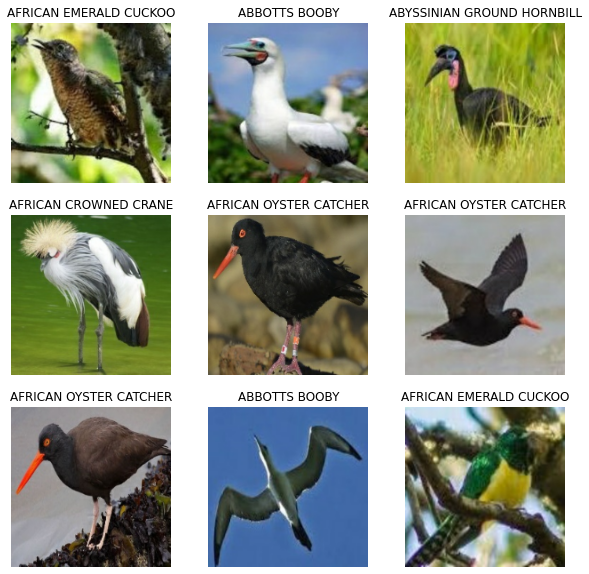

In [4]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
# poner graficos pie chart

## Configurar el conjunto de datos para el rendimiento

In [5]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Estandarización de datos
#### Actualmente las fotos estan en el rango RGB de [0, 255]. Esto no es ideal para una red neuronal, por eso hay que buscar que los valores de entrada sean mas pequeños

In [6]:
rescale_and_resize = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
])

## Aumento de datos
#### El aumento de datos se hace cuando no se tiene muchos datos, ademas ayuda a corregir el overfitting

In [7]:
data_augmentation = tf.keras.Sequential([
	tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
	tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
	tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
])

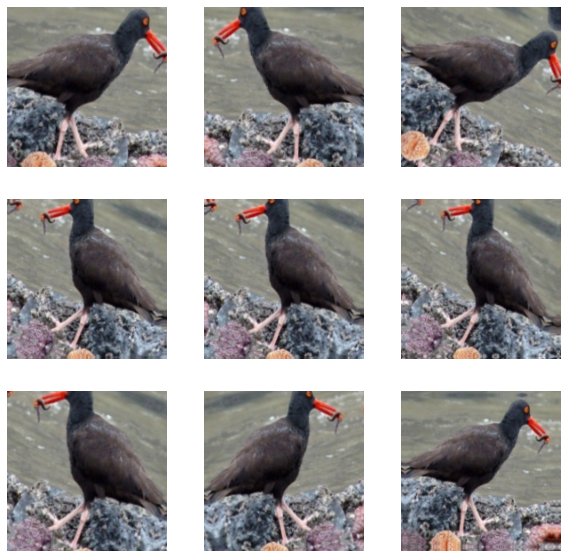

In [8]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## Creación del modelo CNN

In [14]:
def model_builder(hp):
    model = tf.keras.Sequential()
    model.add(rescale_and_resize)
    model.add(data_augmentation)
    model.add(layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)))
    model.add(layers.MaxPooling2D())
    model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
    model.add(layers.MaxPooling2D())
    model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
    model.add(layers.MaxPooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.Flatten(input_shape=(28, 28)))
    
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512
    hp_units = hp.Int('units', min_value = 32, max_value = 512, step = 32)
    model.add(layers.Dense(units = hp_units, activation = 'relu'))
    model.add(layers.Dense(10))

    # Tune the learning rate for the optimizer 
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4]) 
    
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = hp_learning_rate),
                    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True), 
                    metrics = ['accuracy'])
    
    return model

In [11]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 180, 180, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 180, 180, 3)         0         
                                                                 
 module_wrapper (ModuleWrapp  (32, 180, 180, 16)       448       
 er)                                                             
                                                                 
 module_wrapper_1 (ModuleWra  (32, 90, 90, 16)         0         
 pper)                                                           
                                                                 
 module_wrapper_2 (ModuleWra  (32, 90, 90, 32)         4640      
 pper)                                                           
                                                      

In [51]:
tuner = kt.Hyperband(
    hypermodel=model_builder,
    objective="val_accuracy",
    max_epochs=EPOCHS,
    overwrite=True,
    project_name='hyperband_tuner'
)

In [52]:
# checkpointer = ModelCheckpoint(filepath='saved_models/model_vanilla.hdf5', 
#                                monitor='val_accuracy', mode='max',
#                                verbose=1, save_best_only=True) # que si ha mejorado el modelo lo guarde
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=2, min_lr=0.001)
callbacks=[early_stopping, reduce_lr]

In [65]:
tuner.search(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=callbacks)


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
192               |?                 |units
0.001             |?                 |learning_rate
2                 |?                 |tuner/epochs
0                 |?                 |tuner/initial_epoch
3                 |?                 |tuner/bracket
0                 |?                 |tuner/round

Epoch 1/2


ValueError: in user code:

    File "c:\Users\aritz\OneDrive\Escritorio\MUUUH\3. maila\2\PBL\IA\image_processing\lib\site-packages\keras\engine\training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\aritz\OneDrive\Escritorio\MUUUH\3. maila\2\PBL\IA\image_processing\lib\site-packages\keras\engine\training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\aritz\OneDrive\Escritorio\MUUUH\3. maila\2\PBL\IA\image_processing\lib\site-packages\keras\engine\training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\aritz\OneDrive\Escritorio\MUUUH\3. maila\2\PBL\IA\image_processing\lib\site-packages\keras\engine\training.py", line 860, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\aritz\OneDrive\Escritorio\MUUUH\3. maila\2\PBL\IA\image_processing\lib\site-packages\keras\engine\training.py", line 918, in compute_loss
        return self.compiled_loss(
    File "c:\Users\aritz\OneDrive\Escritorio\MUUUH\3. maila\2\PBL\IA\image_processing\lib\site-packages\keras\engine\compile_utils.py", line 201, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\aritz\OneDrive\Escritorio\MUUUH\3. maila\2\PBL\IA\image_processing\lib\site-packages\keras\losses.py", line 141, in __call__
        losses = call_fn(y_true, y_pred)
    File "c:\Users\aritz\OneDrive\Escritorio\MUUUH\3. maila\2\PBL\IA\image_processing\lib\site-packages\keras\losses.py", line 245, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\aritz\OneDrive\Escritorio\MUUUH\3. maila\2\PBL\IA\image_processing\lib\site-packages\keras\losses.py", line 1862, in sparse_categorical_crossentropy
        return backend.sparse_categorical_crossentropy(
    File "c:\Users\aritz\OneDrive\Escritorio\MUUUH\3. maila\2\PBL\IA\image_processing\lib\site-packages\keras\backend.py", line 5202, in sparse_categorical_crossentropy
        res = tf.nn.sparse_softmax_cross_entropy_with_logits(

    ValueError: `labels.shape` must equal `logits.shape` except for the last dimension. Received: labels.shape=(224,) and logits.shape=(32, 10)


In [27]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
27/27 [==============================] - 16s 563ms/step - loss: 1.8619 - accuracy: 0.2326 - val_loss: 1.7408 - val_accuracy: 0.3628 - lr: 0.0010
Epoch 2/50
27/27 [==============================] - 14s 530ms/step - loss: 1.4816 - accuracy: 0.4814 - val_loss: 1.2408 - val_accuracy: 0.5628 - lr: 0.0010
Epoch 3/50
27/27 [==============================] - 14s 531ms/step - loss: 1.0907 - accuracy: 0.6198 - val_loss: 0.9088 - val_accuracy: 0.7070 - lr: 0.0010
Epoch 4/50
27/27 [==============================] - 15s 537ms/step - loss: 0.8806 - accuracy: 0.7081 - val_loss: 0.9393 - val_accuracy: 0.6651 - lr: 0.0010
Epoch 5/50
27/27 [==============================] - 14s 535ms/step - loss: 0.7587 - accuracy: 0.7465 - val_loss: 0.8665 - val_accuracy: 0.7302 - lr: 0.0010
Epoch 6/50
27/27 [==============================] - 14s 534ms/step - loss: 0.7051 - accuracy: 0.7500 - val_loss: 1.2015 - val_accuracy: 0.6419 - lr: 0.0010
Epoch 7/50
27/27 [==============================] - 14s 537ms/st

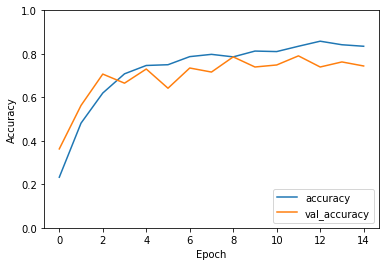

In [28]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')


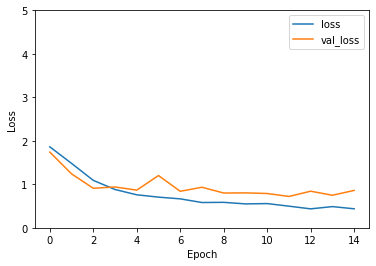

In [29]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 5])
plt.legend(loc='upper right')

In [ ]:
score1 = model.evaluate(val_ds, verbose=1)

7/7 [==============================] - 1s 107ms/step - loss: 0.9006 - accuracy: 0.8233
